* Source: https://www.youtube.com/watch?v=VMj-3S1tku0

In [7]:
import math
import numpy as np
from graphviz import Digraph

**Value Class**

In [8]:
def infixExprLabel(value):
    return f"({value._op.join([str(p.label) for p in value._prev])})" if value._prev else str(value.data)

def prefixExprLabel(value):
    return f"{value._op} {' '.join([str(p.label) for p in value._prev])} " if value._prev else str(value.data)

class Value:
    def __init__(self, data, _prev=(), _op='', label=None):
        self.data = data
        self.grad = 0
        self._prev = _prev
        self._op = _op
        self.label = label if label else infixExprLabel(self)
        self._backwards = lambda: None

    def __repr__(self):
        return f"Value(data={self.data:5f} grad={self.grad:5f})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backwards():
            self.grad += out.grad
            other.grad += out.grad
        out._backwards = _backwards
        return out

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backwards():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backwards = _backwards
        return out

    def __pow__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data ** other.data, (self, other), '**')
        def _backwards():
            self.grad += other.data * self.data**(other.data-1) * out.grad
            other.grad += (math.log(self.data) * self.data**other.data) * out.grad
        out._backwards = _backwards
        return out

    def __sub__(self, other):
        return self + -1 * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other

**Basic Neural Net**

In [9]:
def dot(x, y):
    assert len(x) == len(y), "shape mismatch x: {}, y: {}".format(len(x), len(y))
    sum = x[0] * y[0]
    for i in range(1, len(x)):
        sum += x[i] * y[i]
    return sum

class Neuron:
    def __init__(self, in_features):
        self.weights = [Value(w, label='w') for w in np.random.randn(in_features)]
        self.bias = Value(np.random.randn(), label='b')
        self.activation = Value(0.)

    def activate(self, x):
        self.activation = dot(self.weights, x) + self.bias
        return self.activation

class FullyConnectedLayer:
    def __init__(self, in_features, out_features):
        self.neurons = [Neuron(in_features) for _ in range(out_features)]

    def activate(self, x):
        return [neuron.activate(x) for neuron in self.neurons]

class Network:
    def __init__(self, input_size, hidden_size, output_size):
        self.layers = [
            FullyConnectedLayer(input_size, hidden_size), 
            FullyConnectedLayer(hidden_size, output_size)
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.activate(x)
        return x

net = Network(input_size=1, hidden_size=3, output_size=1)

input = np.random.randn(1)
output = net.forward(input)
print('input', input)
print('output', output)

input [0.54793766]
output [Value(data=-2.868995 grad=0.000000)]


**draw_graph()**

In [10]:
def draw_graph(node, connectToNodeId=None, graph=None):
    if graph is None:
        graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodeId = str(id(node))

    # draw me:
    label = f"{node.label} | {node.data:.5f} | grad: {node.grad:0.5f}" if node.label else f"{node.data:.5f} | grad: {node.grad:0.5f}"
    graph.node(nodeId, label = label, shape='record')

    if connectToNodeId:
        graph.edge(nodeId, connectToNodeId)

    # if result of operator, draw operator node:
    if node._op:
        opNodeId = str(id(node)) + node._op
        graph.node(opNodeId, label=node._op, shape='circle') # draw operator node
        graph.edge(opNodeId, nodeId) # connect me to it

        for p in node._prev:
            draw_graph(p, opNodeId, graph)

    return graph

**Drawing the numeric derivative**

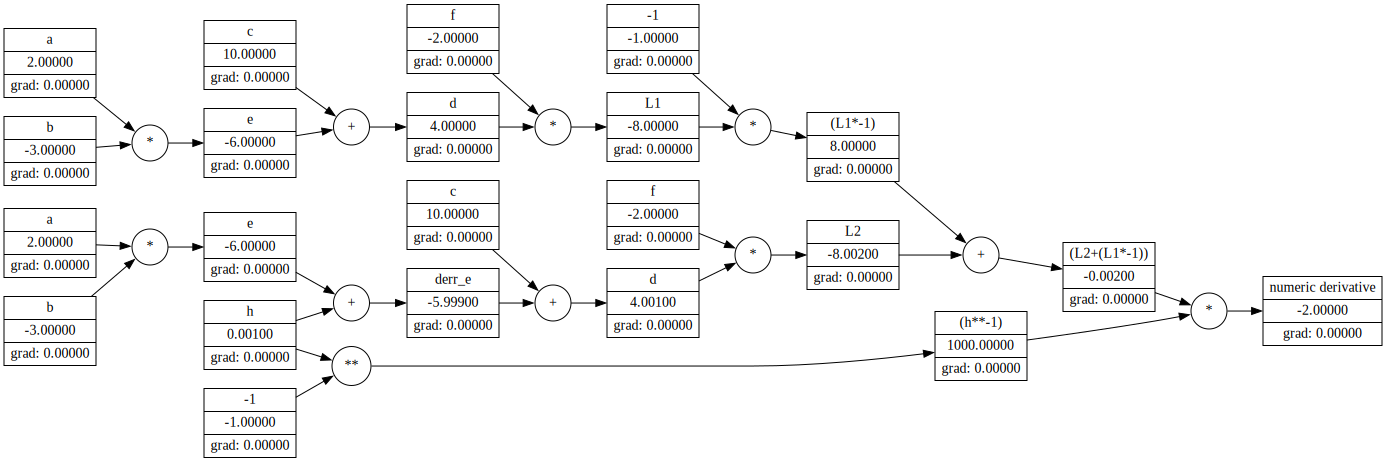

In [11]:
h = Value(0.001, label='h')

# L = -2 * (2.0 * -3.0 + 10.0)
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L1'
L1 = L

#     F     A     B      C
# L = -2 * (2.0 * -3.0 + 10.0)
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
e = e + h; e.label = 'derr_e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L2'
L2 = L

x = (L2 - L1)/h; x.label = 'numeric derivative'
draw_graph(x)

**Backprop**

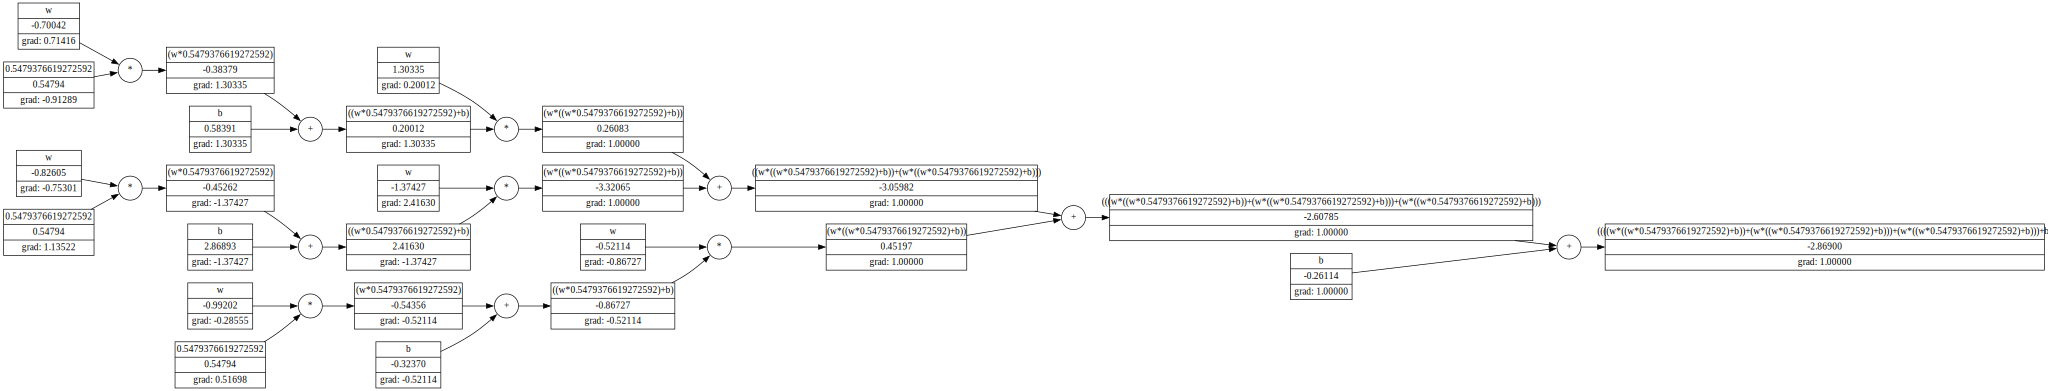

In [12]:
def topological_sort(node, ordered=[]):
    if node not in ordered:
        for p in node._prev:
            topological_sort(p, ordered)
        ordered.append(node)
    return ordered

def backprop_order(node):
    return reversed(topological_sort(node))

def backprop(node):
    node.grad = 1
    for n in backprop_order(node):
        n._backwards()

backprop(output[0])
draw_graph(output[0])